# Model language proficiency based on text characteristics using neural networks

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pickle
import os

import sys
sys.path.append("../movielingo/")

In [2]:
from movielingo.config import processed_data_dir
df = pd.read_csv(processed_data_dir / 'gachon_features_1706_2000.csv', index_col = 0)

In [3]:
df['L2_proficiency'] = df['L2_proficiency'].astype(float)
df['L2_proficiency'] = df['L2_proficiency']/1000 

In [4]:
 # df.hist(figsize=(20,20), bins = 20, color = 'pink');

#### Recode continuous English proficiency scores into classes

- 0: Beginner + Intermediate
- 1: Upper-Intermediate + Advanced

In [4]:
def toeic2cefr(row):
    if row.L2_proficiency < 120/1000:
        return 4
    elif row.L2_proficiency < 255/1000:
        return 0
    elif row.L2_proficiency < 550/1000:
        return 0
    elif row.L2_proficiency < 785/1000:
        return 1
    else:
        return 1

In [5]:
df['cefr'] = df.apply(toeic2cefr, axis = 1)

In [6]:
df.cefr.unique()

array([1, 0])

In [7]:
df = df[df.cefr != 4].reset_index(drop=True)

In [8]:
df.groupby('cefr').count()

,L2_proficiency,n_uniq_lemmas,mean_sent_len,median_sent_len,sd_sent_len,mean_word_len,mean_wf_lemma,mean_wf_token,mean_n_uniq_rare_lemmas,n_unique_verb_forms,...,vp_t,c_t,cp_t,cp_c,cn_t,cn_c,ct_t,t_s,dc_t,dc_c
cefr,,,,,,,,,,,,,,,,,,,,,
0,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,...,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024
1,929,929,929,929,929,929,929,929,929,929,...,929,929,929,929,929,929,929,929,929,929


In [9]:
df.head()

,L2_proficiency,n_uniq_lemmas,mean_sent_len,median_sent_len,sd_sent_len,mean_word_len,mean_wf_lemma,mean_wf_token,mean_n_uniq_rare_lemmas,n_unique_verb_forms,...,c_t,cp_t,cp_c,cn_t,cn_c,ct_t,t_s,dc_t,dc_c,cefr
0,0.78,2.033333,13.125000,12.5,3.479853,105.0,-7.317674,-7.437929,0.016393,0.047619,...,2.000000,0.012500,0.006250,1.375000,0.687500,0.062500,10.0,0.100000,0.050000,1
1,0.78,2.100000,14.571429,15.0,3.886134,102.0,-7.201932,-7.301136,0.015873,0.058824,...,1.571429,0.014286,0.009091,0.242857,0.154545,0.042857,10.0,0.042857,0.027273,1
2,0.78,1.900000,15.000000,16.0,4.035556,105.0,-6.950617,-6.997663,0.017544,0.038095,...,2.142857,0.028571,0.013333,0.242857,0.113333,0.085714,10.0,0.100000,0.046667,1
3,0.78,1.966667,13.625000,10.5,6.081478,109.0,-7.321971,-7.601701,0.016949,0.045872,...,1.625000,0.000000,0.000000,12.637500,7.776923,0.050000,10.0,0.050000,0.030769,1
4,0.78,2.166667,12.300000,9.5,6.841783,123.0,-6.982382,-7.038975,0.015385,0.032520,...,1.700000,0.000000,0.000000,0.290000,0.170588,0.060000,10.0,0.080000,0.047059,1


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=19)

for train_index, test_index in split.split(df, df.cefr):
    learners_train = df.loc[train_index]
    learners_test = df.loc[test_index]

In [11]:
learners_train.columns

Index(['L2_proficiency', 'n_uniq_lemmas', 'mean_sent_len', 'median_sent_len',
       'sd_sent_len', 'mean_word_len', 'mean_wf_lemma', 'mean_wf_token',
       'mean_n_uniq_rare_lemmas', 'n_unique_verb_forms', 'n_unique_past_verbs',
       'n_unique_adj', 'n_unique_adv', 'n_unique_prepos', 'n_unique_modals',
       'n_wh', 'mls', 'mlt', 'mlc', 'c_s', 'vp_t', 'c_t', 'cp_t', 'cp_c',
       'cn_t', 'cn_c', 'ct_t', 't_s', 'dc_t', 'dc_c', 'cefr'],
      dtype='object')

In [12]:
learners_train.drop(columns=["L2_proficiency"], inplace = True)
learners_test.drop(columns=[ "L2_proficiency"], inplace = True)
learners_train_labels = learners_train.cefr
learners_train = learners_train.drop('cefr', axis = 1)
learners_test_labels = learners_test.cefr
learners_test = learners_test.drop('cefr', axis = 1)

In [46]:
learners_train_labels.unique()

array([0, 1])

In [33]:
all_cat_names = []
all_num_names = learners_train.columns
learners_cat = learners_train[all_cat_names]
learners_num = learners_train[all_num_names]

In [16]:
import keras

Using TensorFlow backend.
/opt/anaconda3/envs/insight/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/insight/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/insight/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/insight/lib/python3.7

In [34]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "constant")),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder()),
])

In [52]:
num_attrib = all_num_names
cat_attrib = all_cat_names 

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attrib),
    ('cat', cat_pipeline, cat_attrib),
],sparse_threshold=0.06) # for dense

In [71]:
X_tr = prep_pipeline.fit_transform(learners_train)
y_tr = keras.utils.to_categorical(learners_train_labels.values, num_classes= 2)
X_te = prep_pipeline.transform(learners_test)
y_te = keras.utils.to_categorical(learners_test_labels.values, num_classes= 2)

#### If predicting 4 classes: deal with imbalance by either oversampling or weighting

In [53]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.over_sampling import ADASYN
# from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
#                                     KMeansSMOTE)
# X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

In [74]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(learners_train_labels),
#                                                  learners_train_labels)

/opt/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=1082    0
1433    1
1043    1
1087    0
1304    0
       ..
1731    1
1847    0
50      1
1706    0
1553    0
Name: cefr, Length: 1562, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [72]:
from keras import layers
from keras import regularizers

In [73]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l1_l2(l1=0, l2=1e-7),
                    ),
        layers.LeakyReLU(alpha=0.3),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu",
                    kernel_regularizer=regularizers.l1_l2(l1=0, l2=1e-7),
                    ),
        layers.LeakyReLU(alpha=0.3),
      
        layers.Dense(2, activation = "softmax"),
    ]
)

In [75]:
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [77]:
model.fit(X_tr, y_tr,
          batch_size=128,
          epochs=2500)
#class_weight=class_weights

Epoch 1/2500
1562/1562 [==============================] - 0s 62us/step - loss: 0.6643 - categorical_accuracy: 0.6101
Epoch 2/2500
1562/1562 [==============================] - 0s 63us/step - loss: 0.6643 - categorical_accuracy: 0.5858
Epoch 3/2500
1562/1562 [==============================] - 0s 64us/step - loss: 0.6647 - categorical_accuracy: 0.6056
Epoch 4/2500
1562/1562 [==============================] - 0s 60us/step - loss: 0.6594 - categorical_accuracy: 0.6063
Epoch 5/2500
1562/1562 [==============================] - 0s 63us/step - loss: 0.6634 - categorical_accuracy: 0.6088
Epoch 6/2500
1562/1562 [==============================] - 0s 65us/step - loss: 0.6563 - categorical_accuracy: 0.6223
Epoch 7/2500
1562/1562 [==============================] - 0s 56us/step - loss: 0.6618 - categorical_accuracy: 0.6069
Epoch 8/2500
1562/1562 [==============================] - 0s 95us/step - loss: 0.6630 - categorical_accuracy: 0.5986
Epoch 9/2500
1562/1562 [==============================] - 0s 58u

1562/1562 [==============================] - 0s 52us/step - loss: 0.6548 - categorical_accuracy: 0.6312
Epoch 71/2500
1562/1562 [==============================] - 0s 47us/step - loss: 0.6551 - categorical_accuracy: 0.6127
Epoch 72/2500
1562/1562 [==============================] - 0s 47us/step - loss: 0.6555 - categorical_accuracy: 0.6133
Epoch 73/2500
1562/1562 [==============================] - 0s 45us/step - loss: 0.6553 - categorical_accuracy: 0.6223
Epoch 74/2500
1562/1562 [==============================] - 0s 47us/step - loss: 0.6584 - categorical_accuracy: 0.6172
Epoch 75/2500
1562/1562 [==============================] - 0s 46us/step - loss: 0.6541 - categorical_accuracy: 0.6280
Epoch 76/2500
1562/1562 [==============================] - 0s 45us/step - loss: 0.6535 - categorical_accuracy: 0.6255
Epoch 77/2500
1562/1562 [==============================] - 0s 40us/step - loss: 0.6535 - categorical_accuracy: 0.6133
Epoch 78/2500
1562/1562 [==============================] - 0s 44us/ste

KeyboardInterrupt: 

In [78]:
test_loss, test_acc = model.evaluate(X_te, y_te)
print('test_acc: ', test_acc)

391/391 [==============================] - 0s 77us/step
test_acc:  0.6138107180595398


In [81]:
y_pred = model.predict(X_te)

In [87]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1), normalize = 'true')
matrix

array([[0.67804878, 0.32195122],
       [0.45698925, 0.54301075]])

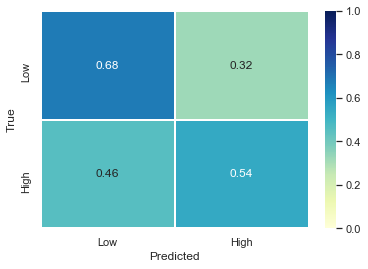

In [141]:
import seaborn as sns
sns.set()
conf = sns.heatmap(matrix, vmin=0, vmax=1, annot=True, linewidths=1, cmap="YlGnBu")
conf.set(xticklabels=['Low', 'High'], yticklabels=['Low','High'], ylabel = 'True', xlabel = 'Predicted');
plt.savefig('confusion_matrix.pdf')